In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport src.utils.training_funcs
%aimport src.models.vae
%aimport src.models.encoder
%aimport src.models.decoder

In [3]:
import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

from src.datasets.irma_dataset import IrmaDataset
from src.utils.transforms import MinMaxScaler
from src.models.vae import VAE
from src.utils.train_val_split import train_val_split
from src.utils.training_funcs import train, validate, kl_reconstruction_loss, get_metrics_str

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
batch_size = 32

dataset = IrmaDataset(transform=transforms.Compose([transforms.ToTensor(),
                                                    MinMaxScaler()
                                                    #   transforms.Grayscale(num_output_channels=1),
                                                    #   transforms.Normalize((0.5,), (0.5,))
                                                    ]))

datasets = train_val_split(dataset, 0.1)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1/0.9)}

dataloaders = {x:DataLoader(datasets[x], batch_size, shuffle=True) for x in ['train','test','val']}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

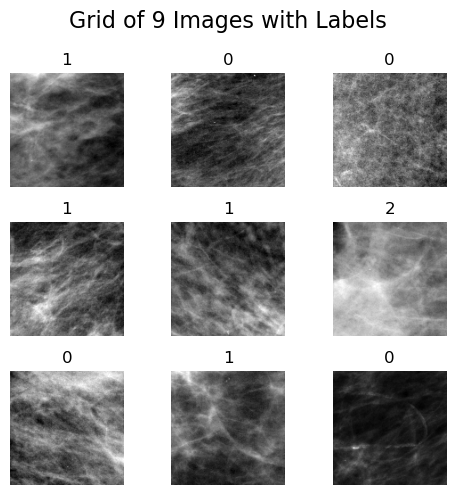

In [6]:
from src.utils.visualization import sample_images

sample_images(dataloaders['train'])

In [7]:
ae_lucca = VAE(
    latent_dim=32,
    conv_layers=[(5, 128), (3, 96)],
    conv_pooling=[2, 2],
    linear_input=(96, 30, 30),
    linear_layers=[768, 384, 128, 64],
)
summary(ae_lucca, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 96, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 128, 124, 124]       3,328
│    │    └─GELU: 3-2                    [32, 128, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 128, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 96, 60, 60]          110,688
│    │    └─GELU: 3-5                    [32, 96, 60, 60]          --
│    │    └─MaxPool2d: 3-6               [32, 96, 30, 30]          --
│    └─Flatten: 2-2                      [32, 86400]               --
│    └─Sequential: 2-3                   [32, 64]                  --
│    │    └─Linear: 3-7                  [32, 768]                 66,355,968
│    │    └─GELU: 3-8                    [32, 768]                 --

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_lucca.parameters())
ae_lucca.to(device)

hist = train(ae_lucca, optimizer, dataloaders['train'], dataloaders['val'], 16, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 91.7144 train_rec_loss: 90.1350 train_kl_loss: 1.5794 - val_loss: 17.5687 val_rec_loss: 17.4778 val_kl_loss: 0.0909
[epoch: 2] train_loss: 14.2448 train_rec_loss: 14.1386 train_kl_loss: 0.1062 - val_loss: 12.9999 val_rec_loss: 12.8748 val_kl_loss: 0.1251
[epoch: 3] train_loss: 11.2570 train_rec_loss: 11.1318 train_kl_loss: 0.1252 - val_loss: 9.4852 val_rec_loss: 9.3442 val_kl_loss: 0.1410
[epoch: 4] train_loss: 8.8024 train_rec_loss: 8.6609 train_kl_loss: 0.1415 - val_loss: 8.8783 val_rec_loss: 8.7394 val_kl_loss: 0.1389
[epoch: 5] train_loss: 8.4082 train_rec_loss: 8.2721 train_kl_loss: 0.1361 - val_loss: 8.6708 val_rec_loss: 8.5340 val_kl_loss: 0.1368
[epoch: 6] train_loss: 8.2316 train_rec_loss: 8.1012 train_kl_loss: 0.1303 - val_loss: 8.4011 val_rec_loss: 8.2715 val_kl_loss: 0.1296
[epoch: 7] train_loss: 8.1376 train_rec_loss: 8.0143 train_kl_loss: 0.1233 - val_loss: 8.1408 val_rec_loss: 8.0148 val_kl_loss: 0.1259
[epoch: 8] train_loss: 7.5593 train_rec_loss:

In [9]:
test_metrics = validate(ae_lucca, dataloaders['test'], kl_reconstruction_loss)
# test_metrics = {k: v/len(datasets['test']) for k, v in test_metrics.items()}

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 0.0122 test_rec_loss: 0.0120 test_kl_loss: 0.0002


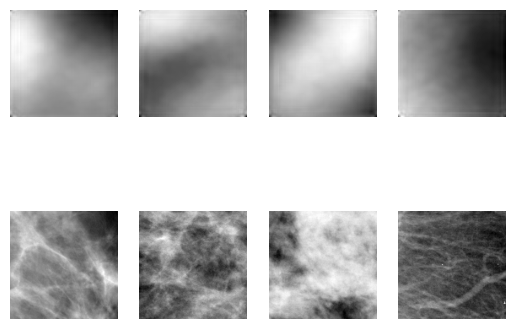

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = ae_lucca(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            reconstructed = inv_normalize(reconstructed)      # unnormalize
            original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

In [11]:
ae_leo = VAE(
    latent_dim=32,
    conv_layers=[(5, 64), (3, 128), (3, 256)],
    conv_pooling=[2, 2, 2],
    linear_input=(256, 14, 14),
    linear_layers=[512, 256, 128, 64],
)
summary(ae_leo, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [32, 64, 124, 124]        1,664
│    │    └─GELU: 3-2                    [32, 64, 124, 124]        --
│    │    └─MaxPool2d: 3-3               [32, 64, 62, 62]          --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         73,856
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 256, 28, 28]         295,168
│    │    └─GELU: 3-8                    [32, 256, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 256, 14, 14]         --
│    └─Flatten: 2-2                      [32, 50176]               --
│  

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo.parameters())
ae_leo.to(device)

hist = train(ae_leo, optimizer, dataloaders['train'], dataloaders['val'], 16, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 54.1979 train_rec_loss: 54.1759 train_kl_loss: 0.0220 - val_loss: 26.2478 val_rec_loss: 26.1977 val_kl_loss: 0.0501
[epoch: 2] train_loss: 16.8459 train_rec_loss: 16.7178 train_kl_loss: 0.1280 - val_loss: 13.3157 val_rec_loss: 13.1483 val_kl_loss: 0.1674
[epoch: 3] train_loss: 11.8906 train_rec_loss: 11.7028 train_kl_loss: 0.1878 - val_loss: 11.7530 val_rec_loss: 11.5695 val_kl_loss: 0.1835
[epoch: 4] train_loss: 10.4422 train_rec_loss: 10.2558 train_kl_loss: 0.1863 - val_loss: 9.5422 val_rec_loss: 9.3211 val_kl_loss: 0.2212
[epoch: 5] train_loss: 8.7353 train_rec_loss: 8.5410 train_kl_loss: 0.1944 - val_loss: 8.9320 val_rec_loss: 8.7364 val_kl_loss: 0.1956
[epoch: 6] train_loss: 8.5066 train_rec_loss: 8.3414 train_kl_loss: 0.1652 - val_loss: 8.4638 val_rec_loss: 8.3000 val_kl_loss: 0.1638
[epoch: 7] train_loss: 8.2917 train_rec_loss: 8.1419 train_kl_loss: 0.1498 - val_loss: 8.3743 val_rec_loss: 8.2323 val_kl_loss: 0.1419
[epoch: 8] train_loss: 7.8835 train_rec_l

In [13]:
test_metrics = validate(ae_leo, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 6.3093 test_rec_loss: 6.1981 test_kl_loss: 0.1112


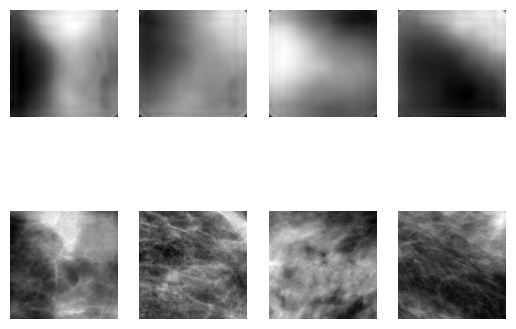

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = ae_leo(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            reconstructed = inv_normalize(reconstructed)      # unnormalize
            original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

In [12]:
ae_leo_latent_dim64 = VAE(
    latent_dim=64,
    conv_layers=[(5, 256), (3, 192), (3, 128), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
)
summary(ae_leo_latent_dim64, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 256, 124, 124]       6,656
│    │    └─GELU: 3-2                    [32, 256, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 256, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 192, 60, 60]         442,560
│    │    └─GELU: 3-5                    [32, 192, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 192, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 128, 28, 28]         221,312
│    │    └─GELU: 3-8                    [32, 128, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 128, 14, 14]         --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          73,79

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_latent_dim64.parameters())
ae_leo_latent_dim64.to(device)

hist = train(ae_leo_latent_dim64, optimizer, dataloaders['train'], dataloaders['val'], 16, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 27.9165 train_rec_loss: 27.8975 train_kl_loss: 0.0189 - val_loss: 18.4042 val_rec_loss: 18.3389 val_kl_loss: 0.0652
[epoch: 2] train_loss: 12.5299 train_rec_loss: 12.4232 train_kl_loss: 0.1067 - val_loss: 9.5115 val_rec_loss: 9.3882 val_kl_loss: 0.1233
[epoch: 3] train_loss: 9.1607 train_rec_loss: 9.0649 train_kl_loss: 0.0958 - val_loss: 8.4834 val_rec_loss: 8.3835 val_kl_loss: 0.0999
[epoch: 4] train_loss: 8.4444 train_rec_loss: 8.3531 train_kl_loss: 0.0912 - val_loss: 8.3748 val_rec_loss: 8.3040 val_kl_loss: 0.0708
[epoch: 5] train_loss: 7.2414 train_rec_loss: 7.1435 train_kl_loss: 0.0980 - val_loss: 6.7749 val_rec_loss: 6.6791 val_kl_loss: 0.0958
[epoch: 6] train_loss: 6.7985 train_rec_loss: 6.7069 train_kl_loss: 0.0916 - val_loss: 6.5869 val_rec_loss: 6.4914 val_kl_loss: 0.0955
[epoch: 7] train_loss: 6.2614 train_rec_loss: 6.1684 train_kl_loss: 0.0930 - val_loss: 5.9243 val_rec_loss: 5.8314 val_kl_loss: 0.0929
[epoch: 8] train_loss: 5.8921 train_rec_loss: 5.7

In [14]:
hist2 = train(ae_leo_latent_dim64, optimizer, dataloaders['train'], dataloaders['val'], 16, kl_reconstruction_loss)

[epoch: 1] train_loss: 4.7209 train_rec_loss: 4.6293 train_kl_loss: 0.0916 - val_loss: 4.6868 val_rec_loss: 4.5926 val_kl_loss: 0.0942
[epoch: 2] train_loss: 4.6163 train_rec_loss: 4.5240 train_kl_loss: 0.0922 - val_loss: 4.6263 val_rec_loss: 4.5356 val_kl_loss: 0.0907
[epoch: 3] train_loss: 4.5335 train_rec_loss: 4.4406 train_kl_loss: 0.0930 - val_loss: 4.4817 val_rec_loss: 4.3873 val_kl_loss: 0.0944
[epoch: 4] train_loss: 4.4575 train_rec_loss: 4.3650 train_kl_loss: 0.0925 - val_loss: 4.4598 val_rec_loss: 4.3655 val_kl_loss: 0.0943
[epoch: 5] train_loss: 4.4298 train_rec_loss: 4.3381 train_kl_loss: 0.0917 - val_loss: 4.3962 val_rec_loss: 4.3035 val_kl_loss: 0.0926
[epoch: 6] train_loss: 4.6242 train_rec_loss: 4.5333 train_kl_loss: 0.0909 - val_loss: 4.9374 val_rec_loss: 4.8392 val_kl_loss: 0.0982
[epoch: 7] train_loss: 4.4180 train_rec_loss: 4.3224 train_kl_loss: 0.0956 - val_loss: 4.4627 val_rec_loss: 4.3632 val_kl_loss: 0.0996
[epoch: 8] train_loss: 4.2983 train_rec_loss: 4.2047 tr

In [15]:
test_metrics = validate(ae_leo_latent_dim64, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 4.2593 test_rec_loss: 4.1679 test_kl_loss: 0.0913


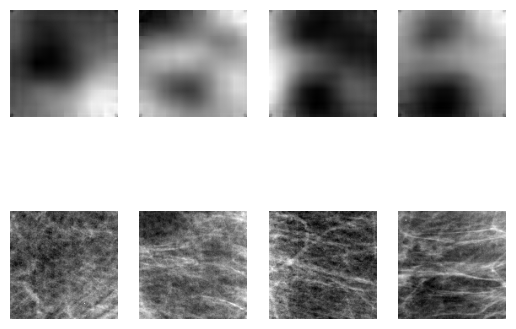

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = ae_leo_latent_dim64(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            reconstructed = inv_normalize(reconstructed)      # unnormalize
            original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

In [23]:
ae_leo_128 = VAE(
    latent_dim=128,
    conv_layers=[(5, 64), (3, 128), (3, 256)],
    conv_pooling=[2, 2, 2],
    linear_input=(256, 14, 14),
    linear_layers=[512, 256, 128, 64],
)
summary(ae_leo_128, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [32, 64, 124, 124]        1,664
│    │    └─GELU: 3-2                    [32, 64, 124, 124]        --
│    │    └─MaxPool2d: 3-3               [32, 64, 62, 62]          --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         73,856
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 256, 28, 28]         295,168
│    │    └─GELU: 3-8                    [32, 256, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 256, 14, 14]         --
│    └─Flatten: 2-2                      [32, 50176]               --
│  

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_128.parameters())
ae_leo_128.to(device)

hist = train(ae_leo_128, optimizer, dataloaders['train'], dataloaders['val'], 24, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 27.4951 train_rec_loss: 27.4813 train_kl_loss: 0.0137 - val_loss: 18.9377 val_rec_loss: 18.9315 val_kl_loss: 0.0062
[epoch: 2] train_loss: 13.3047 train_rec_loss: 13.2463 train_kl_loss: 0.0584 - val_loss: 10.9342 val_rec_loss: 10.8599 val_kl_loss: 0.0743
[epoch: 3] train_loss: 10.4531 train_rec_loss: 10.3838 train_kl_loss: 0.0693 - val_loss: 8.7762 val_rec_loss: 8.7163 val_kl_loss: 0.0599
[epoch: 4] train_loss: 8.3345 train_rec_loss: 8.2602 train_kl_loss: 0.0744 - val_loss: 8.0417 val_rec_loss: 7.9661 val_kl_loss: 0.0756
[epoch: 5] train_loss: 8.0919 train_rec_loss: 8.0198 train_kl_loss: 0.0721 - val_loss: 7.8146 val_rec_loss: 7.7364 val_kl_loss: 0.0782
[epoch: 6] train_loss: 8.0489 train_rec_loss: 7.9798 train_kl_loss: 0.0691 - val_loss: 7.8407 val_rec_loss: 7.7729 val_kl_loss: 0.0678
[epoch: 7] train_loss: 8.0480 train_rec_loss: 7.9801 train_kl_loss: 0.0680 - val_loss: 7.9351 val_rec_loss: 7.8659 val_kl_loss: 0.0693
[epoch: 8] train_loss: 7.9449 train_rec_loss:

In [27]:
test_metrics = validate(ae_leo_128, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 5.6625 test_rec_loss: 5.5917 test_kl_loss: 0.0709


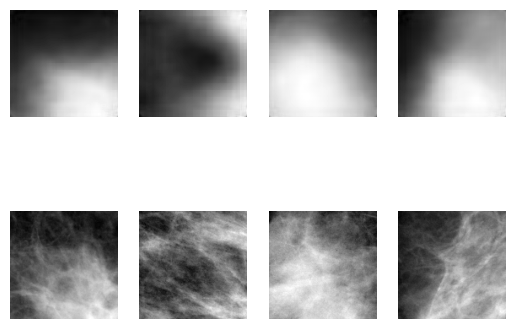

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = ae_leo_128(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            reconstructed = inv_normalize(reconstructed)      # unnormalize
            original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break

In [9]:
ae_leo_128_big = VAE(
    latent_dim=128,
    conv_layers=[(5, 256), (3, 192), (3, 128), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
)
summary(ae_leo_128_big, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 256, 124, 124]       6,656
│    │    └─GELU: 3-2                    [32, 256, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 256, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 192, 60, 60]         442,560
│    │    └─GELU: 3-5                    [32, 192, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 192, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 128, 28, 28]         221,312
│    │    └─GELU: 3-8                    [32, 128, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 128, 14, 14]         --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          73,79

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_128_big.parameters())
ae_leo_128_big.to(device)

hist = train(ae_leo_128_big, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 23.1001 train_rec_loss: 23.0774 train_kl_loss: 0.0227 - val_loss: 12.7109 val_rec_loss: 12.6686 val_kl_loss: 0.0423
[epoch: 2] train_loss: 9.9252 train_rec_loss: 9.8726 train_kl_loss: 0.0527 - val_loss: 9.1498 val_rec_loss: 9.0951 val_kl_loss: 0.0547
[epoch: 3] train_loss: 8.5207 train_rec_loss: 8.4645 train_kl_loss: 0.0561 - val_loss: 8.0886 val_rec_loss: 8.0304 val_kl_loss: 0.0581
[epoch: 4] train_loss: 7.3081 train_rec_loss: 7.2425 train_kl_loss: 0.0656 - val_loss: 6.9669 val_rec_loss: 6.8999 val_kl_loss: 0.0670
[epoch: 5] train_loss: 7.0278 train_rec_loss: 6.9612 train_kl_loss: 0.0666 - val_loss: 6.8565 val_rec_loss: 6.7861 val_kl_loss: 0.0704
[epoch: 6] train_loss: 6.3744 train_rec_loss: 6.3071 train_kl_loss: 0.0673 - val_loss: 6.1847 val_rec_loss: 6.1183 val_kl_loss: 0.0664
[epoch: 7] train_loss: 5.9441 train_rec_loss: 5.8741 train_kl_loss: 0.0700 - val_loss: 5.8892 val_rec_loss: 5.8204 val_kl_loss: 0.0688
[epoch: 8] train_loss: 5.6510 train_rec_loss: 5.579

In [11]:
test_metrics = validate(ae_leo_128_big, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 4.5255 test_rec_loss: 4.4522 test_kl_loss: 0.0733


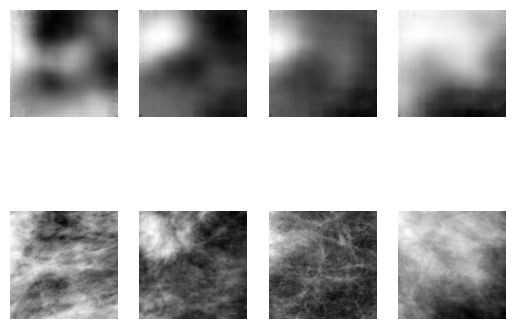

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4)
inv_normalize = transforms.Normalize((-1,), (2,))

with torch.no_grad():
    for i, data in enumerate(dataloaders['test'], 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = ae_leo_128_big(inputs)

        for ax, reconstructed, original in zip(range(4), outputs[0], inputs):
            reconstructed = inv_normalize(reconstructed)      # unnormalize
            original = inv_normalize(original)                # unnormalize
            # original = original / 2 + 0.5     # unnormalize
            # print(reconstructed[0])
            # print(original[0])

            axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
            # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
            axs[1][ax].imshow(original[0].cpu(), cmap='gray')
            # axs[1][ax].imshow(original.cpu().permute(1,2,0))
            axs[0][ax].axis('off')
            axs[1][ax].axis('off')
        plt.show()

        break